In [113]:
%matplotlib inline

from urllib.request import urlretrieve
import zipfile

import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [114]:
# lif parameters
lif_neurons = nengo.LIF(tau_rc=0.02, tau_ref=0.002, amplitude=0.01)

# softlif parameters (lif parameters + sigma)
softlif_neurons = nengo_dl.SoftLIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=0.01,
                                       sigma=0.002)

# ensemble parameters
ens_params = dict(max_rates=nengo.dists.Choice([100]), intercepts=nengo.dists.Choice([0]))



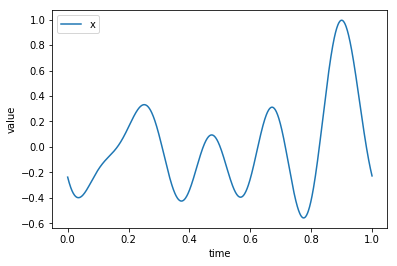

In [115]:
with nengo.Network(seed=0) as net:
    x = nengo.Node(output=nengo.processes.WhiteSignal(1, 5, rms=0.3, seed=0))

inp = x.output.run(1.0)
plt.figure()
plt.plot(np.linspace(0, 1, 1000), inp, label="x")
plt.xlabel("time")
plt.ylabel("value")
plt.legend();

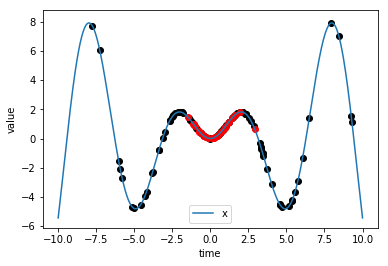

In [116]:
train = 3.5 * np.random.randn(100)
test = 1.5 * np.random.randn(30)
target = np.linspace(-10, 10, 1000)
y = lambda x: x * np.sin(x)
plt.figure()
plt.plot(target, y(target), label="x")
plt.scatter(train,y(train), color='black')
plt.scatter(test,y(test), color='red')
plt.xlabel("time")
plt.ylabel("value")
plt.legend();

In [117]:
n_steps = 1

In [118]:
traint = np.tile(train[:,None],n_steps)[...,None]
testt = np.tile(test[:,None],n_steps)[...,None]

In [119]:
traint.shape

(100, 1, 1)

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


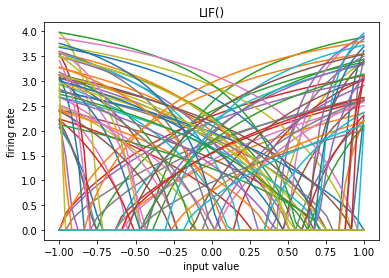

/usr/local/lib/python3.6/site-packages/nengo_dl/simulator.py:1218: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x118f6ff28>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  "are properly freed." % self.model, RuntimeWarning)


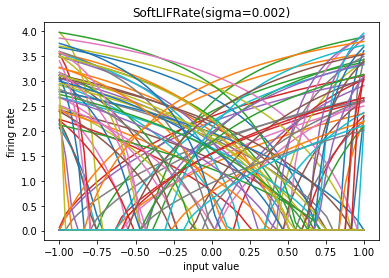

In [128]:
# plot some example LIF tuning curves
for neuron_type in (lif_neurons, softlif_neurons):
    with nengo.Network(seed=0) as net:
        ens = nengo.Ensemble(100, 1, neuron_type=neuron_type)

    with nengo_dl.Simulator(net,device="/cpu:0") as sim:
        plt.figure()
        plt.plot(*nengo.utils.ensemble.tuning_curves(ens, sim))
        plt.xlabel("input value")
        plt.ylabel("firing rate")
        plt.title(str(neuron_type))

In [258]:
def build_network(neuron_type):
    with nengo.Network() as net:
        # we'll make all the nengo objects in the network
        # non-trainable. we could train them if we wanted, but they don't
        # add any representational power so we can save some computation
        # by ignoring them. note that this doesn't affect the internal
        # components of tensornodes, which will always be trainable or
        # non-trainable depending on the code written in the tensornode.
        nengo_dl.configure_settings(trainable=False)

        # the input node that will be used to feed in input images
        #inp = nengo.Node(nengo.processes.PresentInput(train, 0.1))
        inp = nengo.Node([0])
        
        # add a dense layer, with neural nonlinearity.
        # note that for all-to-all connections like this we can use the
        # normal nengo connection transform to implement the weights
        # (instead of using a separate tensor_layer). we'll use a
        # Glorot uniform distribution to initialize the weights.
        x, conn = nengo_dl.tensor_layer(
            inp, neuron_type, **ens_params, transform=nengo_dl.dists.Glorot(),
            shape_in=(1,), return_conn=True)
        # we need to set the weights and biases to be trainable
        # (since we set the default to be trainable=False)
        # note: we used return_conn=True above so that we could access
        # the connection object for this reason.
        net.config[x].trainable = True
        net.config[conn].trainable = True

        # add a dropout layer
        #x = nengo_dl.tensor_layer(x, tf.layers.dropout, rate=0.4)

        # the final 1 dimensional class output
        x = nengo_dl.tensor_layer(x, tf.layers.dense, units=1)

    return net, inp, x

# construct the network
net, inp, out = build_network(softlif_neurons)
with net:
    in_p = nengo.Probe(inp)
    out_p = nengo.Probe(out)

# construct the simulator
minibatch_size = 2
sim = nengo_dl.Simulator(net, minibatch_size=20,tensorboard='/Users/apple1/TFCA')

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               


/usr/local/lib/python3.6/site-packages/nengo_dl/simulator.py:1218: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x119a457f0>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  "are properly freed." % self.model, RuntimeWarning)


Construction finished in 0:00:00                                               


In [259]:
opt = tf.train.MomentumOptimizer(learning_rate=0.002, momentum=0.9, use_nesterov=True)

In [260]:
train_x = {inp: traint}
train_y = {out_p: y(traint)}
test_x = {inp: testt}
test_y = {out_p: y(testt)}

In [261]:
print("error before training: %.2f%%" % sim.loss(test_x, test_y, objective='mse'))

do_training = True
if do_training:
    # run training
    sim.train(train_x, train_y, opt, n_epochs=1000, objective='mse', summaries='loss')

    # save the parameters to file
    sim.save_params("./reg_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&id=0B6DAasV-Fri4WWp0ZFM1XzNfMjA",
        "mnist_params.zip")
    with zipfile.ZipFile("mnist_params.zip") as f:
        f.extractall()

    # load parameters
    sim.load_params("./mnist_params")

print("error after training: %.2f%%" % sim.loss(test_x, test_y, objective='mse'))

sim.close()

INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmp45y32xe_/tmp


/usr/local/lib/python3.6/site-packages/nengo_dl/utils.py:446: UserWarning: Number of inputs (30) is not an even multiple of minibatch size (20); inputs will be truncated
  (n_inputs, minibatch_size)))
INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmp45y32xe_/tmp


error before training: 0.63%


SimulationError: Unknown summary object: l

In [245]:
with nengo_dl.Simulator(net, minibatch_size=100) as sim:
    sim.run_steps(1,input_feeds={inp: traint[:100]})

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:00                                                 


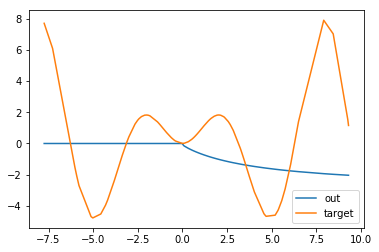

In [246]:
indx = np.argsort(np.squeeze(sim.data[in_p]))
plt.plot(np.squeeze(sim.data[in_p])[indx],np.squeeze(sim.data[out_p])[indx],label='out')
plt.plot(np.squeeze(sim.data[in_p])[indx],np.squeeze(y(sim.data[in_p]))[indx],label='target')
plt.legend()

In [214]:
np.sort(np.squeeze(sim.data[in_p]))

array([-2.6630197 , -2.4393935 , -1.822145  , -1.3294502 , -0.6230425 ,
       -0.46774715, -0.00629115,  0.6859458 ,  0.7275328 ,  0.84005976,
        0.9021213 ,  1.2028817 ,  1.4479944 ,  2.0132635 ,  2.1124127 ,
        2.3453617 ,  4.5581384 ,  5.1914544 ,  5.3463554 ,  6.0587068 ],
      dtype=float32)

In [135]:
net, inp, out = build_network(lif_neurons)
with net:
    out_p = nengo.Probe(out, synapse=0.1)

sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size, unroll_simulation=10)
sim.load_params("./reg_params")

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
INFO:tensorflow:Restoring parameters from ./reg_params


INFO:tensorflow:Restoring parameters from ./reg_params


In [136]:
n_steps = 30
test_inputs_time = {inp: np.tile(v, (1, n_steps, 1)) for v in test_x.values()}
test_targets_time = {out_p: np.tile(v, (1, n_steps, 1)) for v in test_y.values()}

print("spiking neuron error: %.2f%%" % sim.loss(test_inputs_time, test_targets_time,
                                                'mse'))

INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmpjyds9nb2/tmp


INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmpjyds9nb2/tmp


spiking neuron error: 0.61%


In [138]:
sim.run_steps(n_steps, input_feeds={inp: test_inputs_time[inp][:minibatch_size]})
'''
for i in range(5):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(data.test.images[i], (28, 28)))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(sim.trange(), sim.data[out_p][i])
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("time")
'''    

Simulation finished in 0:00:00                                                 


'\nfor i in range(5):\n    plt.figure()\n    plt.subplot(1, 2, 1)\n    plt.imshow(np.reshape(data.test.images[i], (28, 28)))\n    plt.axis(\'off\')\n\n    plt.subplot(1, 2, 2)\n    plt.plot(sim.trange(), sim.data[out_p][i])\n    plt.legend([str(i) for i in range(10)], loc="upper left")\n    plt.xlabel("time")\n'

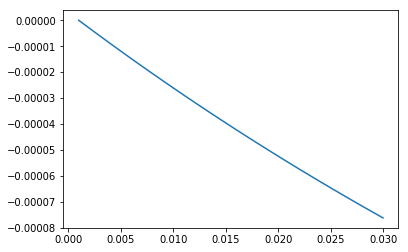

In [139]:
plt.plot(sim.trange(), sim.data[out_p][0])

In [140]:
plt.plot(sim.trange(), y(sim.data[inp]))

AttributeError: 'NoneType' object has no attribute 'sin'

In [145]:
sim.data